In [1]:
from pyspark.sql import SparkSession
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

# Drop old collections if they exist
db["business"].drop()
db["review"].drop()
db["users"].drop()

# Trim and load only first 100000 businesses
with open("data/yelp_academic_dataset_business.json", "r", encoding="utf-8") as f:
    business_data = [json.loads(line) for _, line in zip(range(150346), f)]
db["business"].insert_many(business_data)
print(f"{len(business_data)} businesses")

# Trim and load only first 20000 reviews
with open("data/yelp_academic_dataset_review.json", "r", encoding="utf-8") as f:
    review_data = [json.loads(line) for _, line in zip(range(500000), f)]
db["review"].insert_many(review_data)
print(f"{len(review_data)} reviews")

with open("data/yelp_academic_dataset_user.json", "r", encoding="utf-8") as f:
    user_data = [json.loads(line) for _, line in zip(range(150000), f)]
db["users"].insert_many(user_data)
print(f"{len(user_data)} users")

150346 businesses
500000 reviews
150000 users


In [3]:
#Start the spark session
spark = SparkSession.builder \
    .appName("YelpProject") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [4]:
# Read documents, exclude '_id'
business_docs = list(db["business"].find({}, {"_id": 0}))
review_docs = list(db["review"].find({}, {"_id": 0}))
user_docs = list(db["users"].find({}, {"_id": 0}))

df_business = spark.createDataFrame(business_docs)
df_review = spark.createDataFrame(review_docs)
df_user = spark.createDataFrame(user_docs)

df_business.show(3)
df_review.show(3)
df_user.show(3)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{ByAppointmentOnl...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{BusinessAcceptsC...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{Thursday -> 8:0-...|      1| 38.551126|  -90.335695|    

In [5]:
# Joining business.json and review.json
from pyspark.sql.functions import col

# Rename the 'stars' column in reviews to avoid ambiguity during join
df_review = df_review.withColumnRenamed("stars", "review_stars")

# Perform the join
df_joined = df_review.join(df_business, on="business_id", how="inner")

df_selected = df_joined.select(
    "business_id",
    "name",
    "categories",
    "city",
    "review_stars",
)


In [6]:
from pyspark.sql.functions import avg

df_avg = df_selected.groupBy("business_id", "name", "categories", "city") \
    .agg(avg("review_stars").alias("avg_rating")) \
    .orderBy("avg_rating", ascending=False)

df_avg.show(20, truncate=False)


+----------------------+---------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|business_id           |name                             |categories                                                                                                                                           |city           |avg_rating|
+----------------------+---------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|3-Majgpx_f-xgE7Vo9S-Pg|uBreakiFix                       |Mobile Phone Repair, Electronics Repair, IT Services & Computer Repair, Local Services                                                               |Franklin       |5.0       |
|1oG6bY7TuWEConNDdVi22A|Kindred Hospital Bay Area - Tamp

In [7]:
#top businesses with highest review counts
top_business=df_business.orderBy("review_count", ascending=False).limit(20)
top_business.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|    724 Iberville St|{BikeParking -> F...|_ab50qdWOk0DdB6XO...|Live/Raw Food, Se...|  New Orleans|{Thursday -> 11:0...|      1|   29.9542735|   -90.0689651|   Acme Oyster House|      70130|        7568|  4.0|   LA|
|        739 Conti St|{BikeParking -> T...|ac1AeYqs8Z4_e2X5M...|Restaurants, Seaf...|  New Orleans|{Thursday -> 8:0-...|      1|    29.9

In [8]:
from pyspark.sql.functions import avg

#average star rating per city 
avg_rating_per_city = df_business.groupBy("city").agg(avg("stars").alias("avg_rating"))
avg_rating_per_city.show()

avg_rating_from_cities = avg_rating_per_city.toPandas().to_dict("records")
db["avg_rating_cites"].drop()
db["avg_rating_cities"].insert_many(avg_rating_from_cities)

+-------------------+------------------+
|               city|        avg_rating|
+-------------------+------------------+
|       Harleysville|  3.38265306122449|
|         Westampton|2.9166666666666665|
|        Merion Park|               3.5|
|              Bucks|            4.0625|
|          Worcester|            3.5625|
|        Springfield|3.1888020833333335|
|      Pleasant View|3.2386363636363638|
|            Truckee| 4.636363636363637|
|          Frontenac|3.3947368421052633|
|        Marcus Hook| 3.783333333333333|
|    King Of Prussia|3.0074626865671643|
|     Lafayette Hill|3.7844827586206895|
| Indian Rocks Beach| 3.857142857142857|
|      Lawrenceville| 3.409090909090909|
|        Cherry Hill|3.4052083333333334|
|         Plainfield| 3.356088560885609|
|           Olivette|3.4857142857142858|
|          Levittown|3.3305369127516777|
|         Terra Ceia|               4.5|
|Pittsgrove Township|               4.0|
+-------------------+------------------+
only showing top

InsertManyResult([ObjectId('67f81d4a7d39e73dec9ac0e4'), ObjectId('67f81d4a7d39e73dec9ac0e5'), ObjectId('67f81d4a7d39e73dec9ac0e6'), ObjectId('67f81d4a7d39e73dec9ac0e7'), ObjectId('67f81d4a7d39e73dec9ac0e8'), ObjectId('67f81d4a7d39e73dec9ac0e9'), ObjectId('67f81d4a7d39e73dec9ac0ea'), ObjectId('67f81d4a7d39e73dec9ac0eb'), ObjectId('67f81d4a7d39e73dec9ac0ec'), ObjectId('67f81d4a7d39e73dec9ac0ed'), ObjectId('67f81d4a7d39e73dec9ac0ee'), ObjectId('67f81d4a7d39e73dec9ac0ef'), ObjectId('67f81d4a7d39e73dec9ac0f0'), ObjectId('67f81d4a7d39e73dec9ac0f1'), ObjectId('67f81d4a7d39e73dec9ac0f2'), ObjectId('67f81d4a7d39e73dec9ac0f3'), ObjectId('67f81d4a7d39e73dec9ac0f4'), ObjectId('67f81d4a7d39e73dec9ac0f5'), ObjectId('67f81d4a7d39e73dec9ac0f6'), ObjectId('67f81d4a7d39e73dec9ac0f7'), ObjectId('67f81d4a7d39e73dec9ac0f8'), ObjectId('67f81d4a7d39e73dec9ac0f9'), ObjectId('67f81d4a7d39e73dec9ac0fa'), ObjectId('67f81d4a7d39e73dec9ac0fb'), ObjectId('67f81d4a7d39e73dec9ac0fc'), ObjectId('67f81d4a7d39e73dec9ac0

In [9]:
pipeline = [
    {"$group": {"_id": "$city", "avg_rating": {"$avg": "$stars"}}},
    {"$sort": {"avg_rating": -1}},
    {"$limit": 30}
]
top_cities = list(db.business.aggregate(pipeline))
top_cities

[{'_id': 'Secane ', 'avg_rating': 5.0},
 {'_id': 'LOWER PROVIDENCE', 'avg_rating': 5.0},
 {'_id': 'Picture Rocks', 'avg_rating': 5.0},
 {'_id': 'UPPR BLCK EDY', 'avg_rating': 5.0},
 {'_id': 'Lutz fl', 'avg_rating': 5.0},
 {'_id': 'MERIDIAN', 'avg_rating': 5.0},
 {'_id': 'Sparks,', 'avg_rating': 5.0},
 {'_id': 'Wesley Chapel ', 'avg_rating': 5.0},
 {'_id': 'Edgemoor', 'avg_rating': 5.0},
 {'_id': 'Key Largo', 'avg_rating': 5.0},
 {'_id': 'Dunedin ', 'avg_rating': 5.0},
 {'_id': 'Kings Beach', 'avg_rating': 5.0},
 {'_id': '\u200bLargo', 'avg_rating': 5.0},
 {'_id': 'Ellisville', 'avg_rating': 5.0},
 {'_id': 'Franklin ', 'avg_rating': 5.0},
 {'_id': 'TARPON SPRINGS', 'avg_rating': 5.0},
 {'_id': 'HENDERSONVILLE', 'avg_rating': 5.0},
 {'_id': 'South Lake Tahoe', 'avg_rating': 5.0},
 {'_id': 'Rosewood Heights', 'avg_rating': 5.0},
 {'_id': 'Carpinteria ', 'avg_rating': 5.0},
 {'_id': 'elmwood', 'avg_rating': 5.0},
 {'_id': 'Fernley', 'avg_rating': 5.0},
 {'_id': 'Indianapolis city (balance)

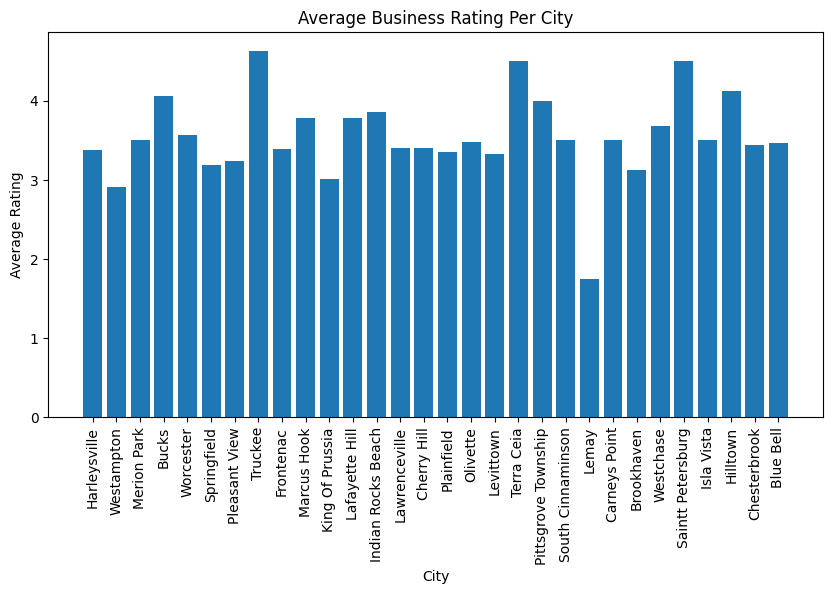

In [10]:
#overall average rating per city
pandas_df = avg_rating_per_city.toPandas()
top_30_cities = pandas_df.head(30)
plt.figure(figsize=(10,5))
plt.bar(top_30_cities["city"], top_30_cities["avg_rating"])
plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Average Rating")
plt.title("Average Business Rating Per City")
plt.show()

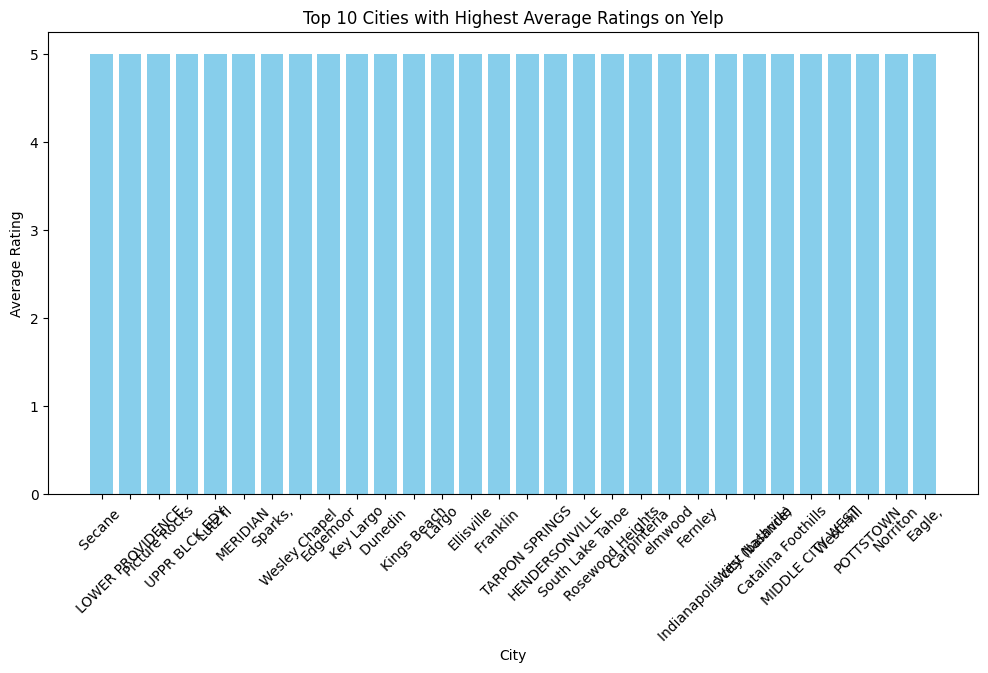

In [11]:
#top 30 cities

df_top_cities = pd.DataFrame(top_cities)

df_top_cities.rename(columns={"_id": "City", "avg_rating": "Average Rating"}, inplace=True)

df_top_cities = df_top_cities.sort_values(by="Average Rating", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_top_cities["City"], df_top_cities["Average Rating"], color="skyblue")

plt.xlabel("City")
plt.ylabel("Average Rating")
plt.title("Top 10 Cities with Highest Average Ratings on Yelp")
plt.xticks(rotation=45)  # Rotate city names for better readability

plt.show()


In [12]:
from pyspark.sql.functions import explode, split


category_counts = df_business.withColumn("category", explode(split(df_business["categories"], ", "))) \
                             .groupBy("category").count() \
                             .orderBy("count", ascending=False)

category_counts.show(10) 

+----------------+-----+
|        category|count|
+----------------+-----+
|     Restaurants|52268|
|            Food|27781|
|        Shopping|24395|
|   Home Services|14356|
|   Beauty & Spas|14292|
|       Nightlife|12281|
|Health & Medical|11890|
|  Local Services|11198|
|            Bars|11065|
|      Automotive|10773|
+----------------+-----+
only showing top 10 rows



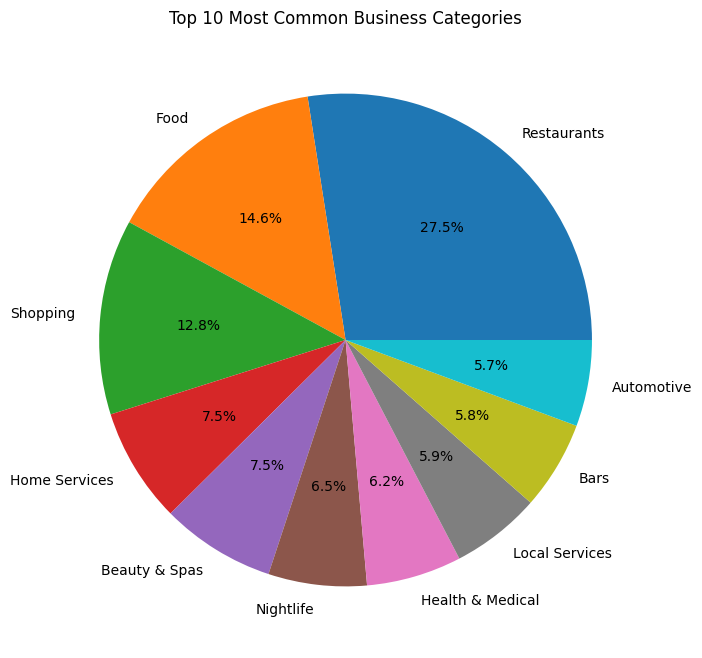

In [13]:
# Top 10 most common business categories

top_categories = category_counts.toPandas().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_categories["count"], labels=top_categories["category"], autopct="%1.1f%%")
plt.title("Top 10 Most Common Business Categories")
plt.show()

In [14]:
df_business.createOrReplaceTempView("business")
spark.sql("SELECT city, AVG(stars) FROM business GROUP BY city ORDER BY AVG(stars) DESC LIMIT 10").show()

+--------------+----------+
|          city|avg(stars)|
+--------------+----------+
|Santa Barbara |       5.0|
| Pass-a-Grille|       5.0|
|        SPARKS|       5.0|
|       Fernley|       5.0|
|       Secane |       5.0|
|  Webster Grvs|       5.0|
|      Norriton|       5.0|
|         Reno |       5.0|
|       Arizona|       5.0|
|    Ellisville|       5.0|
+--------------+----------+



In [15]:
from pyspark.sql.functions import col, expr

# Weighted score for a better ranking for restaurants
df_best_restaurants = df_business.filter(df_business["categories"].rlike("(?i)Restaurant")) \
                                .filter(df_business["review_count"] > 400) \
                                .withColumn("weighted_score", expr("stars * log(review_count)")) \
                                .orderBy(col("weighted_score").desc()) \
                                .limit(30)  

df_best_restaurants.show()


+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+------------------+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|    weighted_score|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+------------------+
|      112 19th Ave S|{BikeParking -> T...|GXFMD0Z4jEVZBCsbP...|American (Traditi...|    Nashville|{Thursday -> 11:0...|      1|36.1513871523| -86.7966029393|Hattie B’s Hot Ch...|      37203|        6093|  4.5|   TN|39.217031326118224|
|        51 N 12th St|{BikeParking -> T...|ytynqOUb3hjKe

In [16]:
best_restaurants= df_best_restaurants.toPandas().to_dict("records")
db["best_restaurants"].drop()
db["best_restaurants"].insert_many(best_restaurants)

InsertManyResult([ObjectId('67f81d697d39e73dec9ac66c'), ObjectId('67f81d697d39e73dec9ac66d'), ObjectId('67f81d697d39e73dec9ac66e'), ObjectId('67f81d697d39e73dec9ac66f'), ObjectId('67f81d697d39e73dec9ac670'), ObjectId('67f81d697d39e73dec9ac671'), ObjectId('67f81d697d39e73dec9ac672'), ObjectId('67f81d697d39e73dec9ac673'), ObjectId('67f81d697d39e73dec9ac674'), ObjectId('67f81d697d39e73dec9ac675'), ObjectId('67f81d697d39e73dec9ac676'), ObjectId('67f81d697d39e73dec9ac677'), ObjectId('67f81d697d39e73dec9ac678'), ObjectId('67f81d697d39e73dec9ac679'), ObjectId('67f81d697d39e73dec9ac67a'), ObjectId('67f81d697d39e73dec9ac67b'), ObjectId('67f81d697d39e73dec9ac67c'), ObjectId('67f81d697d39e73dec9ac67d'), ObjectId('67f81d697d39e73dec9ac67e'), ObjectId('67f81d697d39e73dec9ac67f'), ObjectId('67f81d697d39e73dec9ac680'), ObjectId('67f81d697d39e73dec9ac681'), ObjectId('67f81d697d39e73dec9ac682'), ObjectId('67f81d697d39e73dec9ac683'), ObjectId('67f81d697d39e73dec9ac684'), ObjectId('67f81d697d39e73dec9ac6

In [17]:

best_restaurants_docs = list(db["best_restaurants"].find({}, {"_id": 0}))
best_restaurants_df = spark.createDataFrame(best_restaurants_docs)


In [18]:

state_counts = df_business.withColumn("state", explode(split(df_business["state"], ", "))) \
                             .groupBy("state").count() \
                             .orderBy("count", ascending=False)
state_counts.show(20)

+-----+-----+
|state|count|
+-----+-----+
|   PA|34039|
|   FL|26330|
|   TN|12056|
|   IN|11247|
|   MO|10913|
|   LA| 9924|
|   AZ| 9912|
|   NJ| 8536|
|   NV| 7715|
|   AB| 5573|
|   CA| 5203|
|   ID| 4467|
|   DE| 2265|
|   IL| 2145|
|   TX|    4|
|   CO|    3|
|   WA|    2|
|   HI|    2|
|   MA|    2|
|   NC|    1|
+-----+-----+
only showing top 20 rows



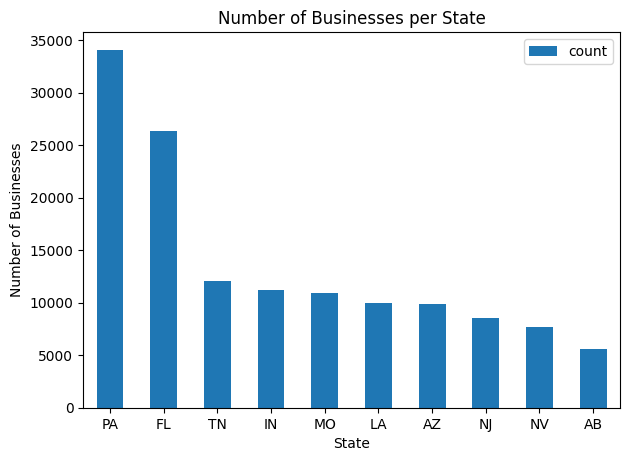

In [19]:
number_of_businesses_per_state = state_counts.toPandas().head(10)
number_of_businesses_per_state.plot(
    kind='bar',
    x='state',
    y='count',
    title='Number of Businesses per State'
)
plt.xlabel("State")

plt.ylabel("Number of Businesses")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

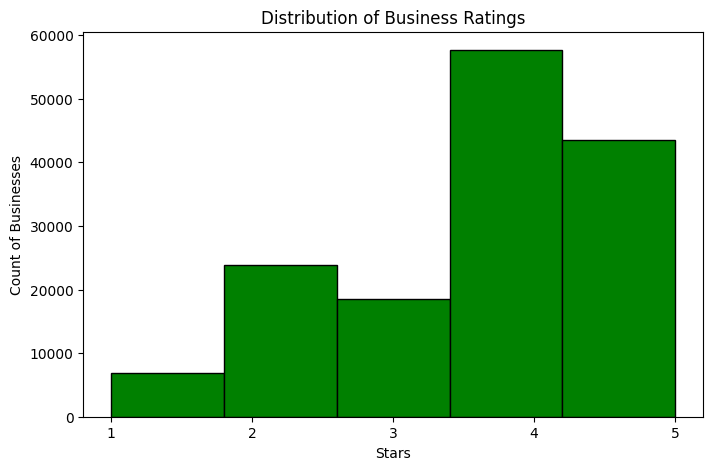

In [20]:
ratings = df_business.select("stars").toPandas()

plt.figure(figsize=(8,5))
plt.hist(ratings["stars"], bins=5, edgecolor='black', color='green')
plt.xlabel("Stars")
plt.ylabel("Count of Businesses")
plt.title("Distribution of Business Ratings")
plt.xticks([1,2,3,4,5])
plt.show()

In [21]:
# Most reviewed businesses

from pyspark.sql.functions import count

df_most_reviewed = df_selected.groupBy("business_id", "name", "categories", "city") \
    .agg(count("review_stars").alias("review_count")) \
    .orderBy("review_count", ascending=False)

df_most_reviewed.show(20, truncate=False)



+----------------------+-------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+------------+
|business_id           |name                                       |categories                                                                                                                                                                                                                |city            |review_count|
+----------------------+-------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+------------+
|GBTPC53ZrG1ZBY3DT8Mbcw|Luke                  

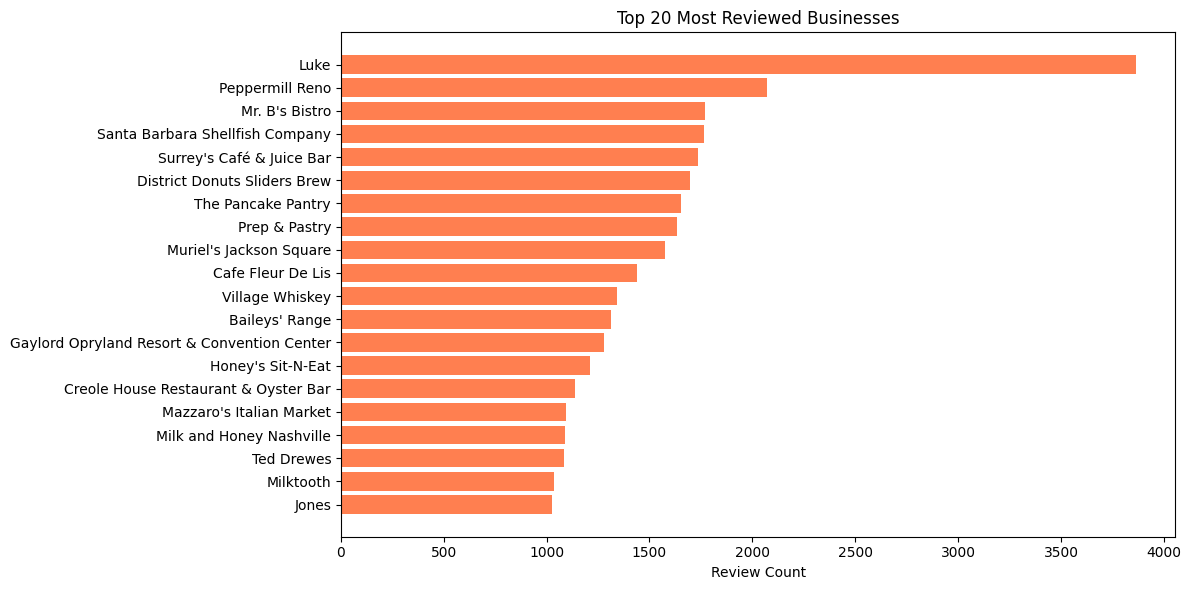

In [22]:


most_reviewed = df_selected.groupBy("business_id", "name") \
    .agg(count("review_stars").alias("review_count")) \
    .orderBy("review_count", ascending=False) \
    .limit(20)

most_reviewed_pd = most_reviewed.toPandas()

plt.figure(figsize=(12, 6))
plt.barh(most_reviewed_pd["name"], most_reviewed_pd["review_count"], color="coral")
plt.xlabel("Review Count")
plt.title("Top 20 Most Reviewed Businesses")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


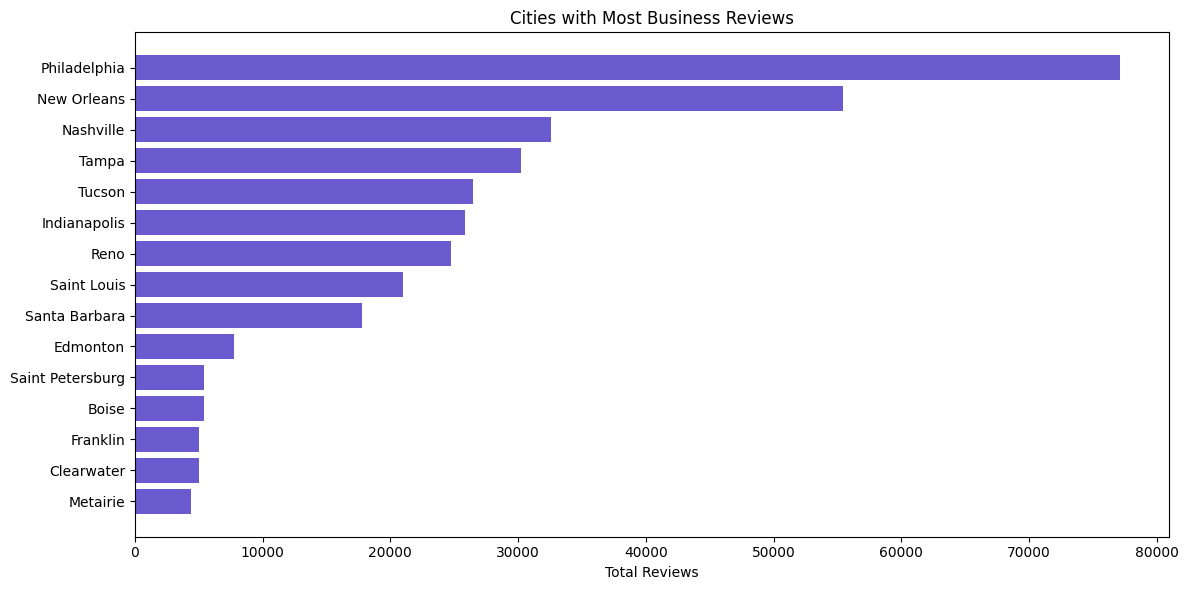

In [23]:
# Most reviews by city

city_activity = df_selected.groupBy("city") \
    .agg(count("review_stars").alias("total_reviews")) \
    .orderBy("total_reviews", ascending=False) \
    .limit(15)

city_activity_pd = city_activity.toPandas()

plt.figure(figsize=(12, 6))
plt.barh(city_activity_pd["city"], city_activity_pd["total_reviews"], color="slateblue")
plt.xlabel("Total Reviews")
plt.title("Cities with Most Business Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


+----------------------+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------+
|business_id           |name                 |categories                                                                                                                                                                                        |city        |avg_rating|
+----------------------+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------+
|efou6IrwQhHAXZ0e0v0Gkw|GYRO CLUB            |Greek, Restaurants, Sports Clubs, Arts & Entertainment, Active Life, Social Clubs                                                                           

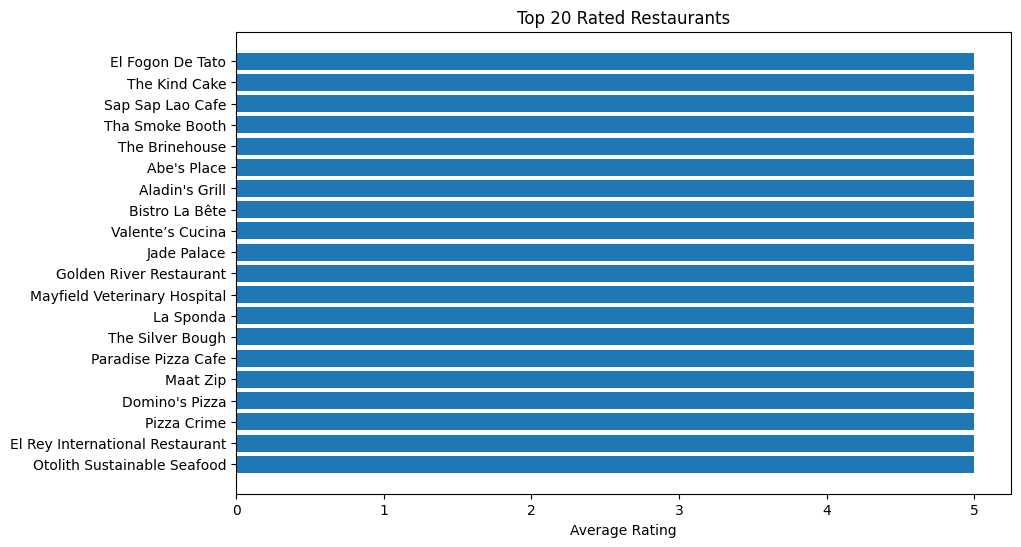

In [24]:
# Top rated restaurants

from pyspark.sql.functions import lower

df_restaurants = df_selected.filter(lower(col("categories")).contains("restaurant"))
df_avg_restaurants = df_restaurants.groupBy("business_id", "name", "categories", "city") \
    .agg(avg("review_stars").alias("avg_rating")) \
    .orderBy("avg_rating", ascending=False)

df_avg_restaurants.show(10, truncate=False)


top10_df = df_avg_restaurants.limit(20).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top10_df["name"], top10_df["avg_rating"])
plt.xlabel("Average Rating")
plt.title("Top 20 Rated Restaurants")
plt.gca().invert_yaxis()
plt.show()
